In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
from scipy.special import gamma

#Group - Aidan Cusa, Kristof Jablonowski, Andrew Yuan

In [2]:
def simulate_binomial(p_true=0.7, n_max=100, n_mc=1000, priors=[(1, 1), (7, 3), (2, 8)]):
    #choose alpha and beta priors -->  alpha/(alpha + beta), uniform, good, and bad estimate
    MSE = np.zeros((len(priors)+1, n_max))  #ML + each prior
    
    for trial in range(n_mc):
        data = np.random.binomial(1, p_true, n_max)
        
        for n in range(1, n_max+1):
            successes = np.sum(data[:n])
            trials = n
            
            p_ML = successes / trials
            MSE[0, n-1] += (p_ML - p_true)**2
            
            for i, (a, b) in enumerate(priors, start=1):
                p_Bayes = (a + successes) / (a + b + trials)
                MSE[i, n-1] += (p_Bayes - p_true)**2
                
        if trial == 0:
            data_saved = data.copy()
    
    MSE /= n_mc
    return MSE, data_saved

In [3]:
def simulate_gaussian_mean(mu_true=5, sigma_known=2, priors=[(0,10),(5,1),(10,0.5)], n_max=100, n_mc=1000):
    #choose mean,variance priors for normal --> high uncertainty, good, bad estimate
    MSE = np.zeros((len(priors)+1, n_max))  #ML + priors
    
    for trial in range(n_mc):
        data = np.random.normal(mu_true, sigma_known, n_max)
        
        for n in range(1, n_max+1):
            mu_ML = np.mean(data[:n])
            MSE[0, n-1] += (mu_ML - mu_true)**2
            
            tau_data = n / sigma_known**2 #using precision = 1/variance to simplify algebra
            
            for i, (mu0, sigma0) in enumerate(priors, start=1):
                tau0 = 1 / sigma0**2
                mu_Bayes = (tau0*mu0 + tau_data*np.mean(data[:n])) / (tau0 + tau_data) #posterior mean
                MSE[i, n-1] += (mu_Bayes - mu_true)**2
        
        if trial == 0:
            data_saved = data.copy()
    
    MSE /= n_mc
    return MSE, data_saved

In [4]:
def simulate_gaussian_variance(mu_known=0, sigma2_true=4, priors=[(2,2),(5,16),(10,10)], n_max=100, n_mc=1000):
    #choose alpha, beta priors for inverse gamma --> post mean = beta/(alpha-1)
    MSE = np.zeros((len(priors)+1, n_max))  #ML + priors
    
    for trial in range(n_mc):
        data = np.random.normal(mu_known, np.sqrt(sigma2_true), n_max)
        
        for n in range(1, n_max+1):
            S = np.sum((data[:n] - mu_known)**2)
            sigma2_ML = S/n
            MSE[0, n-1] += (sigma2_ML - sigma2_true)**2
            
            for i, (a, b) in enumerate(priors, start=1):
                a_post = a + n/2
                b_post = b + S/2
                sigma2_Bayes = b_post / (a_post - 1)
                MSE[i, n-1] += (sigma2_Bayes - sigma2_true)**2
        
        if trial == 0:
            data_saved = data.copy()
    
    MSE /= n_mc
    return MSE, data_saved

In [5]:
def plot_binomial_posteriors(data_saved, p_true=0.7, prior=(7,3), n_points=[0, 5, 10, 25, 50, 100]):
    p_range = np.linspace(0, 1, 1000)
    
    plt.figure(figsize=(8, 5))
    for n in n_points:
        if n == 0:
            a_post, b_post = prior
        else:
            s = np.sum(data_saved[:n])
            a_post, b_post = prior[0] + s, prior[1] + n - s
        plt.plot(p_range, beta.pdf(p_range, a_post, b_post), lw=1.5, label=f"n={n}")
    
    plt.axvline(p_true, color='k', linestyle='--', lw=2, label="Actual probability")
    plt.xlabel("Probability"); plt.ylabel("Density")
    plt.title("Beta Posterior Evolution")
    plt.grid(True)
    plt.legend()
    plt.show()

In [6]:
def plot_gaussian_mean_posteriors(data_saved, mu_true=5, sigma_known=2, prior=(5,1), n_points=[0,5,10,25,50,100]):
    mu_range = np.linspace(-2, 12, 1400)
    
    plt.figure(figsize=(8, 5))
    for n in n_points:
        if n == 0:
            mu_post, sigma_post = prior
        else:
            tau0 = 1/prior[1]**2
            tau_data = n/sigma_known**2
            tau_post = tau0 + tau_data
            mu_post = (tau0*prior[0] + tau_data*np.mean(data_saved[:n])) / tau_post
            sigma_post = np.sqrt(1/tau_post)
        plt.plot(mu_range, norm.pdf(mu_range, mu_post, sigma_post), lw=1.5, label=f"n={n}")
    
    plt.axvline(mu_true, color='k', linestyle='--', lw=2, label="Actual mean")
    plt.xlabel("Mean"); plt.ylabel("Density")
    plt.title("Normal Posterior Evolution")
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
def plot_gaussian_variance_posteriors(data_saved, mu_known=0, sigma2_true=4, prior=(5,16), n_points=[0,5,10,25,50,100]):
    sigma2_range = np.linspace(0.01, 12, 1000)
    
    plt.figure(figsize=(8, 5))
    for n in n_points:
        if n == 0:
            a_post, b_post = prior
        else:
            S = np.sum((data_saved[:n] - mu_known)**2)
            a_post = prior[0] + n/2
            b_post = prior[1] + S/2
        pdf_vals = (b_post**a_post / gamma(a_post)) * sigma2_range**(-a_post-1) * np.exp(-b_post/sigma2_range)
        plt.plot(sigma2_range, pdf_vals, lw=1.5, label=f"n={n}")
    
    plt.axvline(sigma2_true, color='k', linestyle='--', lw=2, label="Actual variance")
    plt.xlabel("Variance"); plt.ylabel("Density")
    plt.title("Inverse-Gamma Posterior Evolution")
    plt.xlim([0,10]); plt.grid(True)
    plt.legend()
    plt.show()

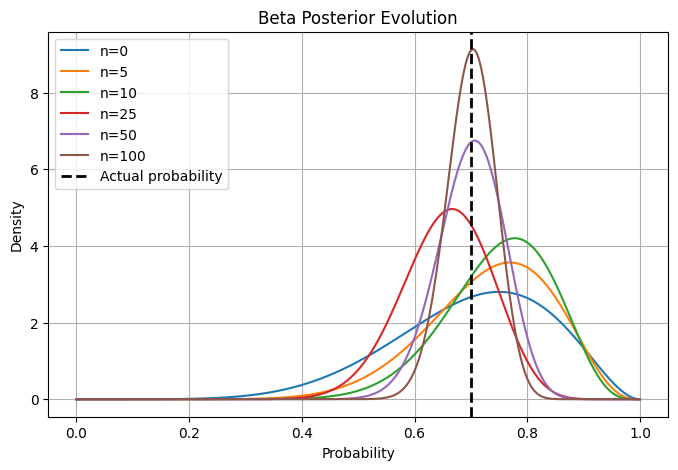

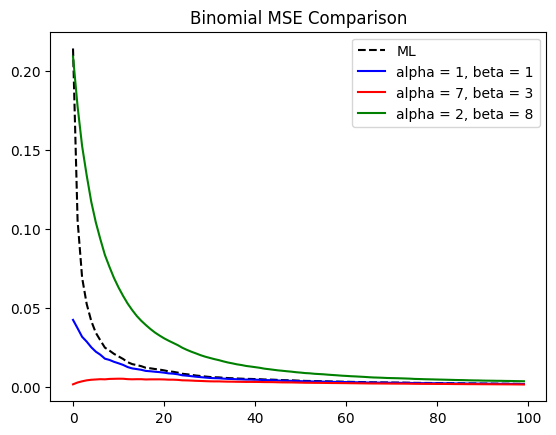

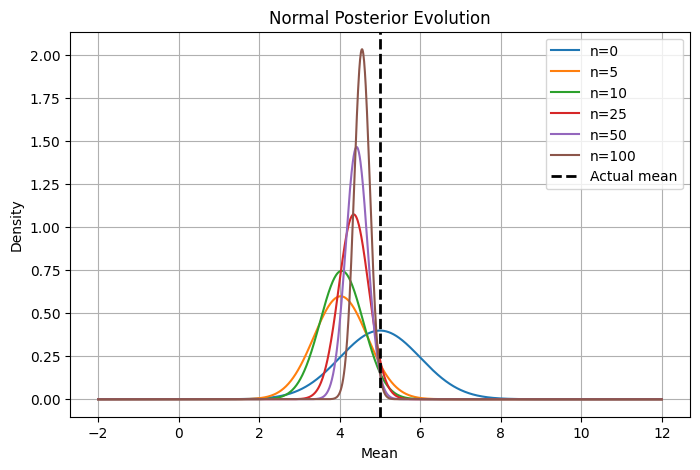

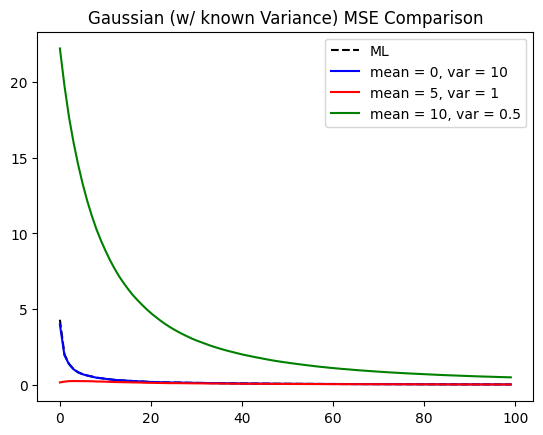

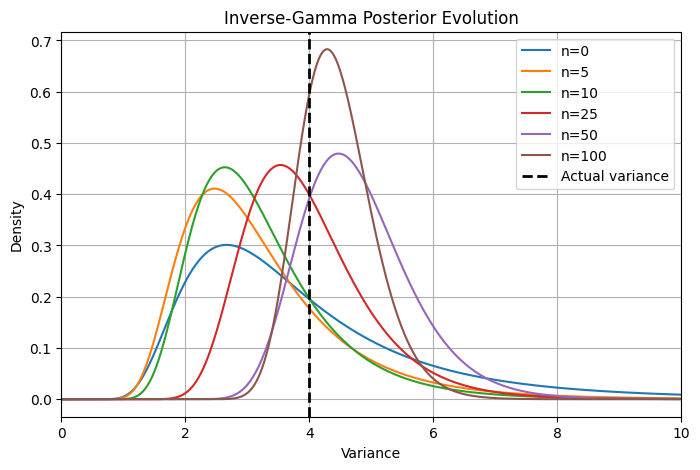

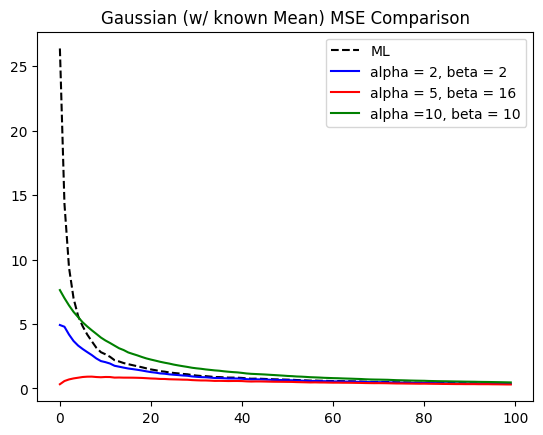

In [8]:
#Plotting Code for all distributions

# Binomial
MSE_binom, data_binom = simulate_binomial()
plot_binomial_posteriors(data_binom)
plt.plot(MSE_binom[0], 'k--', label="ML")
plt.plot(MSE_binom[1], 'b-', label="alpha = 1, beta = 1")
plt.plot(MSE_binom[2], 'r-', label="alpha = 7, beta = 3")
plt.plot(MSE_binom[3], 'g-', label="alpha = 2, beta = 8")
plt.legend(); plt.title("Binomial MSE Comparison"); plt.show()


#Gaussian Mean (variance known)
MSE_mean, data_mean = simulate_gaussian_mean()
plot_gaussian_mean_posteriors(data_mean)
plt.plot(MSE_mean[0], 'k--', label="ML")
plt.plot(MSE_mean[1], 'b-', label="mean = 0, var = 10")
plt.plot(MSE_mean[2], 'r-', label="mean = 5, var = 1")
plt.plot(MSE_mean[3], 'g-', label="mean = 10, var = 0.5")
plt.legend(); plt.title("Gaussian (w/ known Variance) MSE Comparison"); plt.show()

# Gaussian Variance (mean known)
MSE_var, data_var = simulate_gaussian_variance()
plot_gaussian_variance_posteriors(data_var)
plt.plot(MSE_var[0], 'k--', label="ML")
plt.plot(MSE_var[1], 'b-', label="alpha = 2, beta = 2")
plt.plot(MSE_var[2], 'r-', label="alpha = 5, beta = 16")
plt.plot(MSE_var[3], 'g-', label="alpha =10, beta = 10")
plt.legend(); plt.title("Gaussian (w/ known Mean) MSE Comparison"); plt.show()